In [1]:
import fbprophet
import geopandas as gpd
import fiona
import matplotlib.pyplot as plt
import contextily as ctx
import numpy as np

In [2]:
#load vulnerable areas data
gdb_file = 'Climate_Change_Vulnerability_NE/Climate_Change_Vulnerability_NE.gdb'

layers = fiona.listlayers(gdb_file)
for layer in layers:
    v_gdf = gpd.read_file(gdb_file,layer=layer)
    


In [3]:
#load birds data
birds = gpd.read_file('birds_uk_2018_2019.csv')

birds['Latitude (WGS84)'].replace('', np.nan, inplace=True)
birds['Longitude (WGS84)'].replace('', np.nan, inplace=True)

gbirds = gpd.GeoDataFrame(
    birds, geometry=gpd.points_from_xy(x=birds['Longitude (WGS84)'].astype('float'),y=birds['Latitude (WGS84)'].astype('float')))


gbirds.crs = "EPSG:4326"
#gbirds = gbirds.to_crs(epsg=27700)
gbirds = gbirds.to_crs(epsg=3857)
gbirds.head()

/Users/florencehope/opt/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


,Occurrence ID,Family,Genus,Common name,Class,OSGR,Start date,area_represented,OSGR 100km,OSGR 10km,OSGR 2km,OSGR 1km,Latitude (WGS84),Longitude (WGS84),geometry
0,6668696,Paridae,Poecile,Marsh Tit,Aves,SU2607,2018-06-22,2018,SU,SU20,SU20T,SU2607,50.866402,-1.624804,POINT (-180872.354 6597695.720)
1,4747938,Corvidae,Coloeus,Jackdaw,Aves,ST5661,2018-06-19,2018,ST,ST56,ST56Q,ST5661,51.350902,-2.626021,POINT (-292327.321 6683600.525)
2,7136100,Anatidae,Aythya,Tufted Duck,Aves,SU8804,2018-06-15,2018,SU,SU80,SU80X,SU8804,50.833277,-0.744653,POINT (-82894.393 6591855.173)
3,2705782,Corvidae,Pica,Magpie,Aves,NT2687,2018-06-10,2018,NT,NT28,NT28T,NT2687,56.074649,-3.182348,POINT (-354257.359 7573290.535)
4,15685977,Turdidae,Turdus,Song Thrush,Aves,NX4151,2018-06-11,2018,NX,NX45,NX45A,NX4151,54.833173,-4.469262,POINT (-497515.970 7329555.481)


In [4]:
#load biodiversity data
biodiversity = gpd.read_file('biodiversity_species_2011_2019.csv')

biodiversity['Latitude (WGS84)'].replace('', np.nan, inplace=True)
biodiversity['Longitude (WGS84)'].replace('', np.nan, inplace=True)

gbiod = gpd.GeoDataFrame(
    biodiversity, geometry=gpd.points_from_xy(x=biodiversity['Longitude (WGS84)'].astype('float'),y=biodiversity['Latitude (WGS84)'].astype('float')))


gbiod.crs = "EPSG:4326"

#gbiod = gbiod.to_crs(epsg=27700)
gbiod = gbiod.to_crs(epsg=3857)

gbiod.head()

/Users/florencehope/opt/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


,Occurrence ID,Family,Genus,Common name,Class,OSGR,Start date,area_represented,OSGR 100km,OSGR 10km,OSGR 2km,OSGR 1km,Latitude (WGS84),Longitude (WGS84),geometry
0,1507997,Motacillidae,Anthus,Meadow Pipit,Aves,SK41G,,meadow,SK,SK41,SK41G,,52.712959,-1.364931,POINT (-151943.424 6930078.599)
1,MMEEECJAEEEHGLKR,Rosaceae,Fragaria,Wild Strawberry,Magnoliopsida,SN71,,meadow,SN,SN71,,,51.819602,-3.814957,POINT (-424679.071 6767572.678)
2,1242731,Alaudidae,Alauda,Skylark,Aves,SK40N,,meadow,SK,SK40,SK40N,,52.658863,-1.336146,POINT (-148739.092 6920144.420)
3,1507896,Alaudidae,Alauda,Skylark,Aves,SK41G,,meadow,SK,SK41,SK41G,,52.712959,-1.364931,POINT (-151943.424 6930078.599)
4,MMEEECJAEEE0SS3O,Motacillidae,Anthus,Meadow Pipit,Aves,SS79,,meadow,SS,SS79,,,51.63987,-3.80777,POINT (-423879.017 6735269.441)


In [5]:
# load zoomstack data

natp = gpd.read_file('OS_zoomstack_sample/OS_Open_Zoomstack greenspace.geojson')
#natp = natp.to_crs(epsg=27700)
natp = natp.to_crs(epsg=3857)


In [6]:
'''establish grid for dataset linking'''

# total area for the grid
import numpy as np 
import shapely

xmin, ymin, xmax, ymax = gbirds.total_bounds
# how many cells across and down

cell_size = 10000

# projection of the grid
#crs = "EPSG:27700"
crs = "EPSG:3857"

# create the cells in a loop

grid_cells = []

for x0 in np.arange(xmin, xmax+cell_size, cell_size ):
    for y0 in np.arange(ymin, ymax+cell_size, cell_size):
        # bounds
        half_step = cell_size/2
        x1 = x0-cell_size
        y1 = y0+cell_size
        grid_cells.append( shapely.geometry.box(x0 + half_step, y0 + half_step, x1 + half_step, y1 + half_step)  )


start_cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'], 
                                 crs=crs)

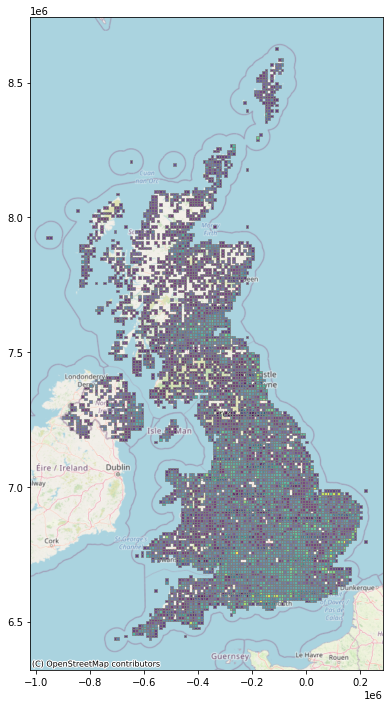

In [7]:
''' grid in birds'''
cell = start_cell

gridded_birds = gpd.sjoin(gbirds, cell, how='left', op='within')
gridded_birds['n_birds']=1

#Compute stats per grid cell -- aggregate fires to grid cells with dissolve
dissolve = gridded_birds.dissolve(by="index_right", aggfunc="count")
cell.loc[dissolve.index, 'n_birds'] = dissolve.n_birds.values

'''add unique species types'''
unique_species_types = gridded_birds.groupby(['index_right'])['Common name'].nunique()
cell.loc[unique_species_types.index, 'n_unique_bird_species'] = unique_species_types.values

'''plot'''
ax = cell.plot(column='n_unique_bird_species', figsize=(16, 12), cmap='viridis', edgecolor="grey",alpha=0.7)
ctx.add_basemap(ax,source=ctx.providers.OpenStreetMap.Mapnik)
plt.autoscale(False)

#ax.axis('off')

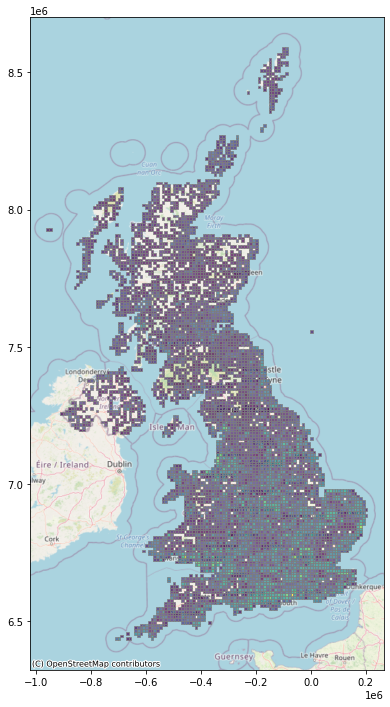

In [8]:
''' grid in biodiversitydata'''
cellbiod = start_cell

gridded_biod = gpd.sjoin(gbiod, cell, how='left', op='within')
gridded_biod['n_bio_species']=1

#Compute stats per grid cell -- aggregate fires to grid cells with dissolve
dissolve = gridded_biod.dissolve(by="index_right", aggfunc="count")
cellbiod.loc[dissolve.index, 'n_bio_species'] = dissolve.n_bio_species.values

'''add unique species types'''
unique_species_types = gridded_biod.groupby(['index_right'])['Common name'].nunique()
cellbiod.loc[unique_species_types.index, 'n_unique_bio_species'] = unique_species_types.values

'''plot'''
ax = cellbiod.plot(column='n_unique_bio_species', figsize=(16, 12), cmap='viridis', edgecolor="grey",alpha=0.7)
ctx.add_basemap(ax,source=ctx.providers.OpenStreetMap.Mapnik)
plt.autoscale(False)



In [9]:
''' grid in land value types'''
cell2 = start_cell
gridded_areas = gpd.sjoin(natp,cell2, how='left', op='within')

gridded_areas['n_areas'] = 1

dissolve_areas = gridded_areas.dissolve(by="index_right", aggfunc="count")

cell2.loc[dissolve_areas.index, 'n_areas'] = dissolve_areas.n_areas.values

'''add unique land types'''
unique_land_types = gridded_areas.groupby(['index_right']).type.nunique()
cell2.loc[unique_land_types.index, 'n_unique_areas'] = unique_land_types.values


'''ax = cell2.plot(column='n_unique_areas', figsize=(16, 12), cmap='viridis', vmax=5000, edgecolor="grey",alpha=0.7)
ctx.add_basemap(ax,source=ctx.providers.OpenStreetMap.Mapnik)
plt.autoscale(False)

ax.axis('off')
'''


'ax = cell2.plot(column=\'n_unique_areas\', figsize=(16, 12), cmap=\'viridis\', vmax=5000, edgecolor="grey",alpha=0.7)\nctx.add_basemap(ax,source=ctx.providers.OpenStreetMap.Mapnik)\nplt.autoscale(False)\n\nax.axis(\'off\')\n'

In [10]:
cell.sort_values('n_unique_bio_species',ascending=False)

,geometry,n_birds,n_unique_bird_species,n_bio_species,n_unique_bio_species,n_areas,n_unique_areas
19685,"POLYGON ((-73855.666 6591817.125, -73855.666 6...",247.0,44.0,135.0,20.0,49.0,9.0
11080,"POLYGON ((-463855.666 6731817.125, -463855.666...",1810.0,118.0,262.0,18.0,37.0,9.0
19702,"POLYGON ((-73855.666 6761817.125, -73855.666 6...",1927.0,104.0,1071.0,18.0,54.0,10.0
25235,"POLYGON ((176144.334 6841817.125, 176144.334 6...",2536.0,118.0,3312.0,17.0,5.0,3.0
24113,"POLYGON ((126144.334 6671817.125, 126144.334 6...",388.0,46.0,1444.0,16.0,19.0,8.0
...,...,...,...,...,...,...,...
26515,"POLYGON ((226144.334 8591817.125, 226144.334 8...",NaN,NaN,NaN,NaN,NaN,NaN
26516,"POLYGON ((226144.334 8601817.125, 226144.334 8...",NaN,NaN,NaN,NaN,NaN,NaN
26517,"POLYGON ((226144.334 8611817.125, 226144.334 8...",NaN,NaN,NaN,NaN,NaN,NaN
26518,"POLYGON ((226144.334 8621817.125, 226144.334 8...",NaN,NaN,NaN,NaN,NaN,NaN


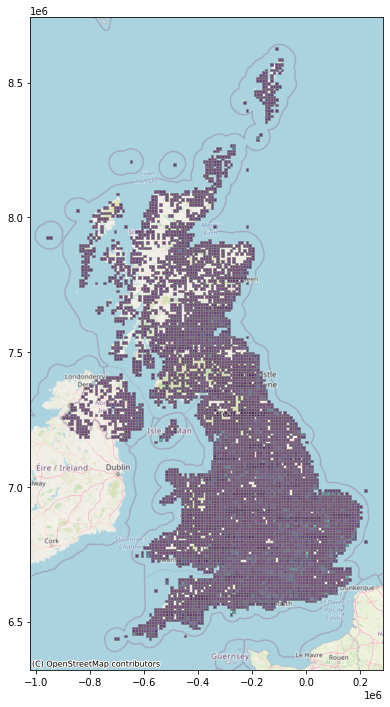

In [11]:
ax = cell.plot(column='n_birds', figsize=(16, 12), cmap='viridis', edgecolor="grey",alpha=0.7)
ctx.add_basemap(ax,source=ctx.providers.OpenStreetMap.Mapnik)
plt.autoscale(False)

In [13]:
cell.to_csv('box_geo_with_aggregates.csv')